c:\Users\abhis\anaconda3\envs\test\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


--- Trajectory Clustering & Classification Script ---
Processing sample folder: '12'
Output directory: 'trajectory_images_clustered'
Background image: 'sample12.jpg'
Ground Truth CSV: 'trajectory_images/combined_labels.csv'

Using thresholds:
  moving_threshold: 10.00 (pixels)
  straightness_threshold: 1.20 (ratio)
  hv_angle_tolerance_deg: 25.00 (degrees)
  turn_threshold: 20.00 degrees
  sudden_change_threshold: 45.00 degrees
  final_segment_straight_tolerance: 25.00 degrees

Central zone polygon defined with 4 vertices.

[Step 1/5] Loading trajectories...
Found 276 CSV files in '12'.
Successfully loaded and resampled 272 valid trajectories.
Skipped 4 files due to errors or insufficient data.
Trajectory loading completed in 0.45 seconds.

[Step 2/5] Loading TRUE labels from CSV...
Loaded 742 labels from ground truth CSV.
Successfully matched 272 ground truth labels.
Ground truth loading completed in 0.01 seconds.
Proceeding with 272 trajectories that have valid ground truth labels.
F

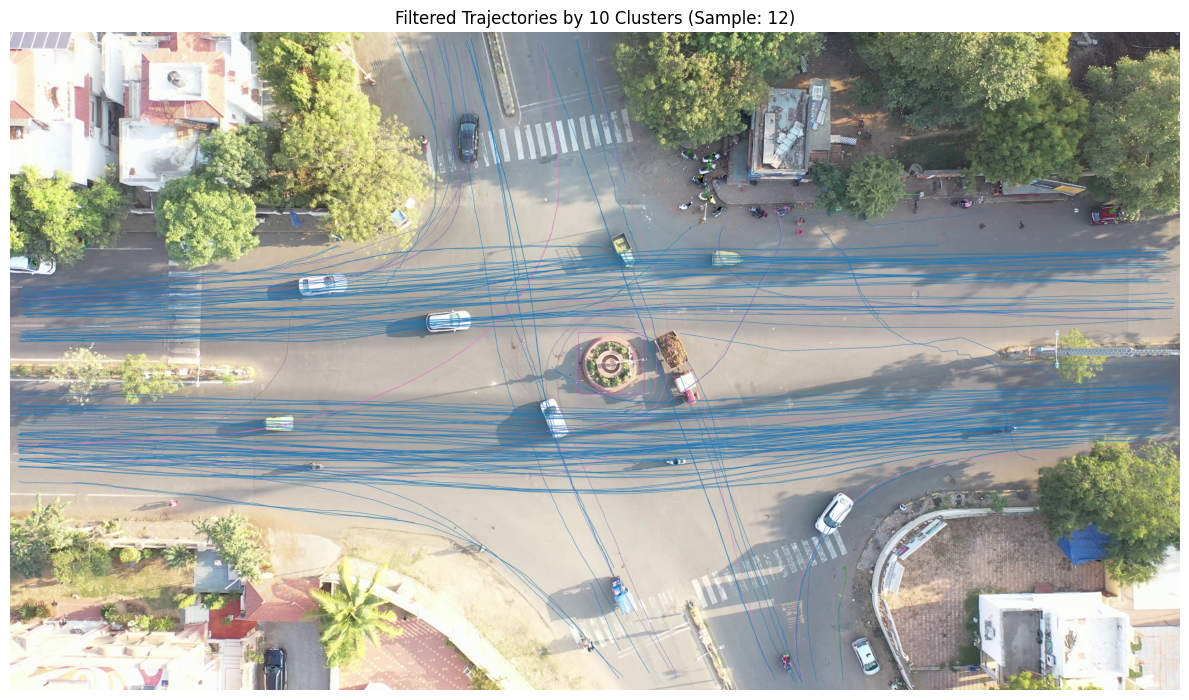


Generating visualization 2/4: Filtered trajectories grid plot (10 clusters)...
Grid plot saved to trajectory_images_clustered\ClusterGrid__12_20250413-145439.png


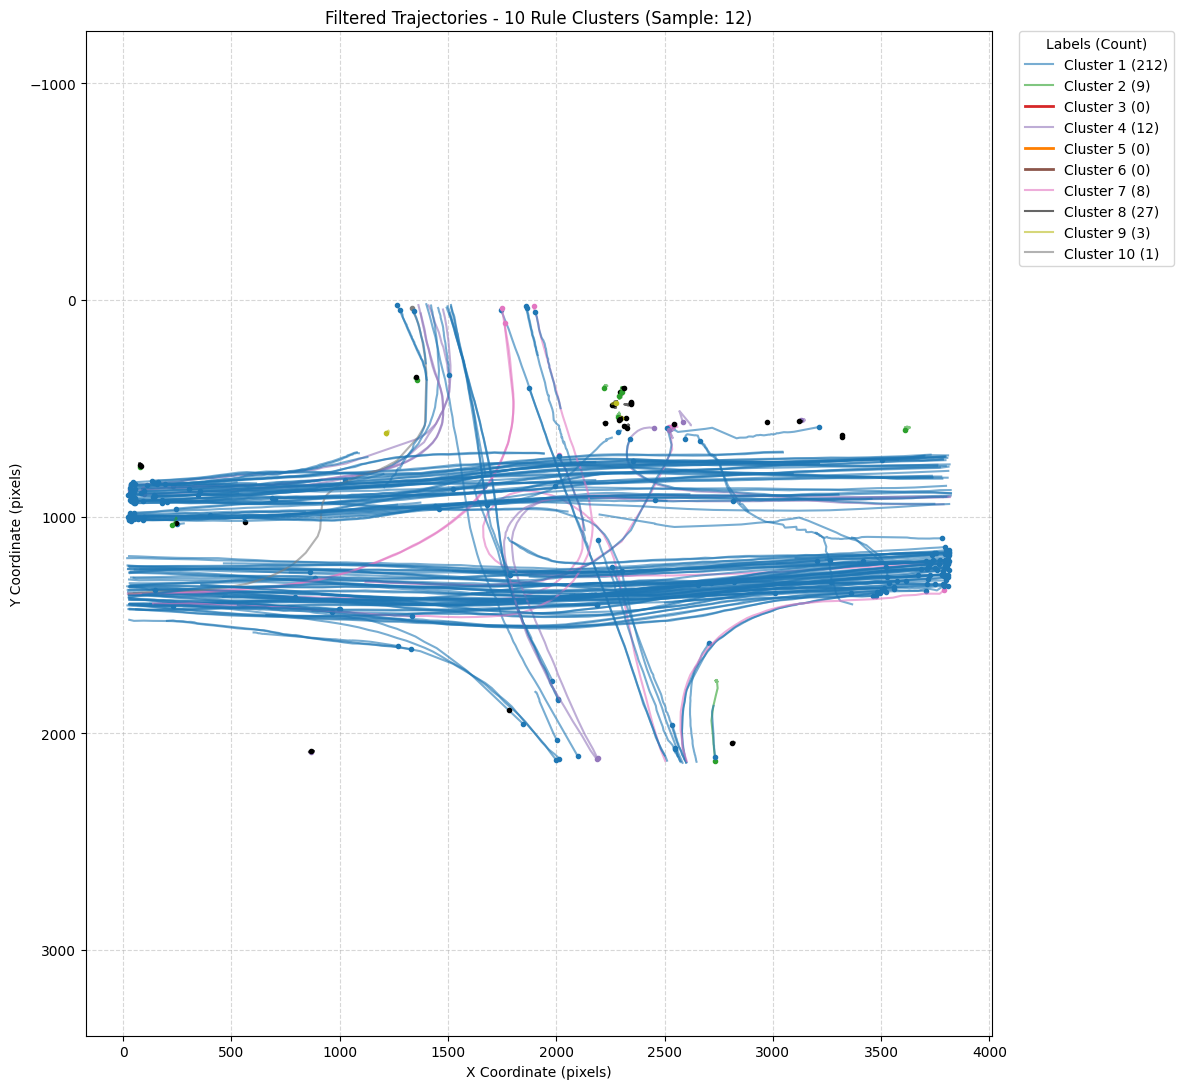


Generating visualization 3/4: Filtered trajectories Binary Classification...
Visualization saved to trajectory_images_clustered\filtered_BinaryClassification_on_image_12_20250413-145439.png


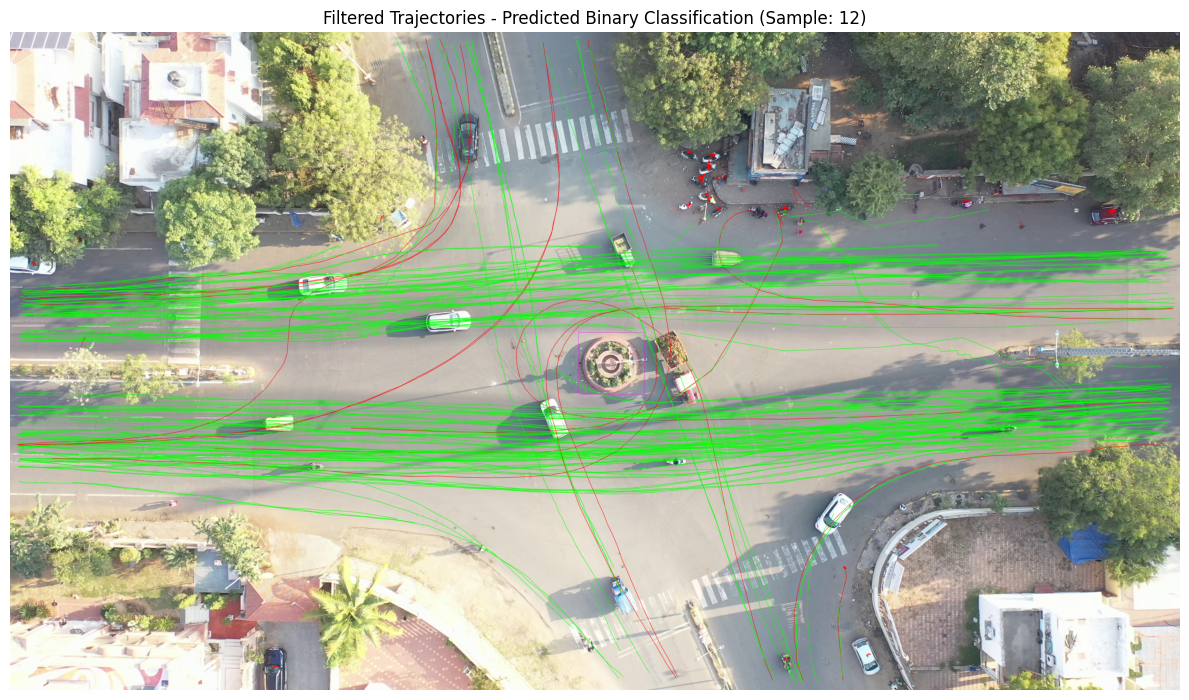


Generating visualization 4/4: Confusion Matrix plot...
Confusion matrix saved to trajectory_images_clustered\ConfusionMatrix_12_20250413-145440.png


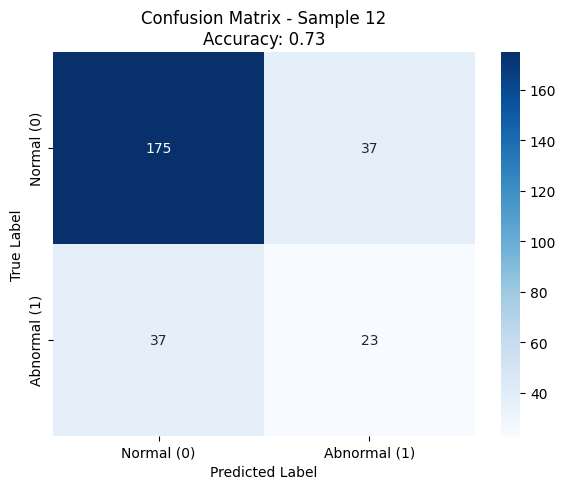


--- Script Finished ---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tslearn.preprocessing import TimeSeriesResampler
import time
import math
from typing import List, Tuple, Optional, Dict, Any
# +++ Import sklearn metrics +++
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns # For prettier confusion matrix plotting

# -----------------------------
# Parameters & Paths
# -----------------------------
sample = "12"  # Process folder "10" (adjust as needed)
folder_path = sample  # Folder containing CSV files for the sample
image_path = f"sample{sample}.jpg"  # Background image for visualization
output_dir = "trajectory_images_clustered"
os.makedirs(output_dir, exist_ok=True)

# +++ Define Ground Truth CSV File Path (USER PROVIDES THIS COMBINED FILE) +++
# Assumes a CSV file with 'filename' and 'label' columns.
# The 'filename' column should contain entries like '10/342_.csv'
# ground_truth_csv_path = "combined_labels.csv" # ADJUST THIS PATH if your file has a different name/location
ground_truth_csv_path = "trajectory_images/combined_labels.csv" # ADJUST THIS PATH if your file has a different name/location

n_points = 50  # Number of points to resample each trajectory

# -----------------------------
# Thresholds for the custom clustering rules
# -----------------------------
threshold_params = {
    'moving_threshold': 10.0,
    'straightness_threshold': 1.2,
    'hv_angle_tolerance_deg': 25.0,
    'turn_threshold': np.deg2rad(20),
    'sudden_change_threshold': np.deg2rad(45),
    'final_segment_straight_tolerance': np.deg2rad(25),
}

# -----------------------------
# Central Junction/Roundabout Zone Polygon (in pixel coordinates)
# -----------------------------
central_zone_polygon = np.array([
    [1866, 987], [1866, 1190], [2081, 1190], [2081, 987]
],dtype=np.int32)

# -----------------------------
# Helper Functions
# -----------------------------
def extract_trajectory(csv_path: str) -> Optional[np.ndarray]:
    """Extracts frame number and center coordinates from a CSV file."""
    try:
        df = pd.read_csv(csv_path, usecols=["frameNo", "left", "top", "w", "h"])
        df["center_x"] = df["left"] + df["w"] / 2
        df["center_y"] = df["top"] + df["h"] / 2
        return df[["frameNo", "center_x", "center_y"]].values
    except FileNotFoundError:
        return None
    except Exception as e:
        print(f"Error processing file {csv_path}: {e}")
        return None

def resample_trajectory(traj: np.ndarray, n_points: int) -> Optional[np.ndarray]:
    """Resamples a trajectory (x, y coordinates) to have a fixed number of points."""
    if not isinstance(traj, np.ndarray) or traj.ndim != 2 or traj.shape[1] != 3 or traj.shape[0] < 2:
        return None
    xy_coords = traj[:, 1:3]
    traj_reshaped = xy_coords.reshape(1, xy_coords.shape[0], 2)
    try:
        traj_reshaped = np.ascontiguousarray(traj_reshaped, dtype=np.float64)
        resampler = TimeSeriesResampler(sz=n_points)
        resampled_xy = resampler.fit_transform(traj_reshaped)[0]
        original_frames = traj[:, 0]
        resampled_frames = np.linspace(original_frames[0], original_frames[-1], n_points)
        resampled_traj = np.column_stack((resampled_frames, resampled_xy))
        return resampled_traj
    except ValueError as ve:
         if "Input array is not initialized" in str(ve) or "number of time steps should be greater than 1" in str(ve):
             return None
         else:
            print(f"Error during resampling (ValueError): {ve}. Trajectory shape: {traj.shape}")
            return None
    except Exception as e:
        print(f"Error during resampling: {e}. Trajectory shape: {traj.shape}")
        return None

# --- MODIFIED: This function loads ONLY trajectories and filenames ---
def load_trajectories(folder_path: str, n_points: int) -> Tuple[List[np.ndarray], List[str]]:
    """ Loads trajectories from CSV files in folder_path and resamples them. """
    if not os.path.isdir(folder_path):
        print(f"Error: Source folder '{folder_path}' not found.")
        return [], []

    all_csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])
    print(f"Found {len(all_csv_files)} CSV files in '{folder_path}'.")

    trajectories = []
    file_names = [] # Store the base filename (e.g., '342_.csv')
    valid_traj_count = 0
    skipped_count = 0

    for fname in all_csv_files:
        full_path = os.path.join(folder_path, fname)
        traj_raw = extract_trajectory(full_path)
        if traj_raw is not None and len(traj_raw) >= 2:
            traj_resampled = resample_trajectory(traj_raw, n_points)
            if traj_resampled is not None:
                trajectories.append(traj_resampled)
                file_names.append(fname) # Store the actual filename found in the folder
                valid_traj_count += 1
            else:
                skipped_count += 1
        else:
            skipped_count +=1

    print(f"Successfully loaded and resampled {valid_traj_count} valid trajectories.")
    if skipped_count > 0:
        print(f"Skipped {skipped_count} files due to errors or insufficient data.")

    return trajectories, file_names

# +++ NEW Function to Load Ground Truth Labels from Combined CSV +++
def load_ground_truth_from_csv(gt_csv_path: str, processed_filenames: List[str]) -> Optional[np.ndarray]:
    """
    Loads ground truth labels from the combined CSV file.
    Matches filenames from the CSV (e.g., '10/342_.csv') with the processed filenames (e.g., '342_.csv').
    Returns labels ordered according to processed_filenames.
    """
    if not os.path.exists(gt_csv_path):
        print(f"Error: Ground truth CSV file not found at '{gt_csv_path}'. Cannot calculate accuracy.")
        return None
    try:
        gt_df = pd.read_csv(gt_csv_path)
        if 'filename' not in gt_df.columns or 'label' not in gt_df.columns:
            print(f"Error: Ground truth CSV '{gt_csv_path}' must contain 'filename' and 'label' columns.")
            return None

        # Create a dictionary for quick lookup: base_filename -> label
        gt_map = {}
        for index, row in gt_df.iterrows():
            csv_filename = row['filename']
            # --- Extract the base filename (part after the '/') ---
            if '/' in csv_filename:
                base_filename = csv_filename.split('/', 1)[-1]
            else:
                base_filename = csv_filename # Handle cases where prefix might be missing
            gt_map[base_filename] = row['label']
        print(f"Loaded {len(gt_map)} labels from ground truth CSV.")

        ground_truth_labels = []
        missing_files = 0
        # --- Match processed filenames with the ground truth map ---
        for fname in processed_filenames:
            # fname is the base filename like '342_.csv'
            if fname in gt_map:
                ground_truth_labels.append(gt_map[fname])
            else:
                print(f"Warning: Filename '{fname}' (from processed data) not found in ground truth CSV '{gt_csv_path}'. Assigning label -1.")
                ground_truth_labels.append(-1) # Use -1 or some indicator for missing GT
                missing_files += 1

        if missing_files > 0:
            print(f"Warning: {missing_files} processed trajectories were missing from the ground truth CSV.")

        gt_labels_array = np.array(ground_truth_labels)
        valid_label_count = np.sum(gt_labels_array != -1)
        print(f"Successfully matched {valid_label_count} ground truth labels.")
        if valid_label_count == 0:
             print("Error: No trajectories could be matched with the ground truth CSV. Check filename formats.")
             return None

        return gt_labels_array

    except Exception as e:
        print(f"Error reading or processing ground truth CSV '{gt_csv_path}': {e}")
        return None


# --- Other helper functions (angle_between_points, smallest_angle_diff, etc.) remain the same ---
def angle_between_points(p1: np.ndarray, p2: np.ndarray) -> float:
    """Compute the angle (radians, -pi to pi) of the vector from p1 to p2."""
    delta = p2 - p1
    if np.linalg.norm(delta) < 1e-9: return 0.0
    return np.arctan2(delta[1], delta[0])

def smallest_angle_diff(angle1: float, angle2: float) -> float:
    """Smallest signed difference (angle1 - angle2) in radians [-pi, pi]."""
    diff = angle1 - angle2
    return (diff + np.pi) % (2 * np.pi) - np.pi

def detect_sudden_change(traj: np.ndarray, change_threshold_rad: float) -> Tuple[bool, float]:
    """Checks if the maximum change in segment direction exceeds the threshold."""
    pts = traj[:, 1:3]
    if len(pts) < 3: return False, 0.0
    segment_vectors = np.diff(pts, axis=0)
    norms = np.linalg.norm(segment_vectors, axis=1)
    non_zero_mask = norms > 1e-6
    valid_vectors = segment_vectors[non_zero_mask]
    if len(valid_vectors) < 2: return False, 0.0
    angles = np.arctan2(valid_vectors[:, 1], valid_vectors[:, 0])
    if len(angles) < 2: return False, 0.0
    angle_diffs = smallest_angle_diff(angles[1:], angles[:-1])
    max_change = np.max(np.abs(angle_diffs)) if angle_diffs.size > 0 else 0.0
    return max_change > change_threshold_rad, max_change

def compute_reference_angles(trajectories: List[np.ndarray], straightness_thresh: float, angle_tolerance_deg: float) -> Tuple[Optional[float], Optional[float]]:
    """Computes reference direction angles for horizontal and vertical straight trajectories."""
    straight_angles_h, straight_angles_v = [], []
    angle_tolerance_rad = np.deg2rad(angle_tolerance_deg)
    for traj in trajectories:
        if traj is None or len(traj) < 2: continue
        pts = traj[:, 1:3]; start, end = pts[0], pts[-1]
        direct_distance = np.linalg.norm(end - start)
        if direct_distance < 1.0: continue
        segment_lengths = np.linalg.norm(np.diff(pts, axis=0), axis=1)
        total_path = np.sum(segment_lengths)
        if direct_distance < 1e-6: continue
        straightness_ratio = total_path / direct_distance
        if straightness_ratio < straightness_thresh:
            traj_angle = angle_between_points(start, end)
            is_h = abs(smallest_angle_diff(traj_angle, 0)) < angle_tolerance_rad or abs(smallest_angle_diff(traj_angle, np.pi)) < angle_tolerance_rad
            is_v = abs(smallest_angle_diff(traj_angle, np.pi/2)) < angle_tolerance_rad or abs(smallest_angle_diff(traj_angle, -np.pi/2)) < angle_tolerance_rad
            if is_h: straight_angles_h.append(traj_angle)
            elif is_v: straight_angles_v.append(traj_angle)

    ref_angle_h, ref_angle_v = None, None
    if straight_angles_h:
        mean_angle_h = np.arctan2(np.mean(np.sin(straight_angles_h)), np.mean(np.cos(straight_angles_h)))
        ref_angle_h = 0 if abs(smallest_angle_diff(mean_angle_h, 0)) < abs(smallest_angle_diff(mean_angle_h, np.pi)) else np.pi
        print(f"Found {len(straight_angles_h)} straight horizontal trajectories. Ref Angle H: {np.rad2deg(ref_angle_h):.1f} deg")
    else:
        print("Warning: No straight horizontal trajectories found for reference. Rule 5 might be unreliable.")
        ref_angle_h = 0 # Provide a default if none found
    if straight_angles_v:
        mean_angle_v = np.arctan2(np.mean(np.sin(straight_angles_v)), np.mean(np.cos(straight_angles_v)))
        ref_angle_v = np.pi/2 if abs(smallest_angle_diff(mean_angle_v, np.pi/2)) < abs(smallest_angle_diff(mean_angle_v, -np.pi/2)) else -np.pi/2
        print(f"Found {len(straight_angles_v)} straight vertical trajectories. Ref Angle V: {np.rad2deg(ref_angle_v):.1f} deg")
    else:
        print("Warning: No straight vertical trajectories found for reference. Rules 3 and 4 might be unreliable.")
        ref_angle_v = np.pi/2 # Provide a default if none found
    return ref_angle_h, ref_angle_v

def intersects_zone(traj: np.ndarray, zone_polygon: np.ndarray) -> bool:
    """Checks if any point of the trajectory falls inside the given polygon zone."""
    if zone_polygon is None or len(zone_polygon) < 3: return False
    points = traj[:, 1:3].astype(np.float32)
    for point in points:
        if cv2.pointPolygonTest(zone_polygon, tuple(point), False) >= 0: return True
    return False

# -----------------------------
# Rule-Based Clustering Logic (10 Rules) - Unchanged
# -----------------------------
def assign_custom_cluster_10(traj: np.ndarray, ref_angle_h: Optional[float], ref_angle_v: Optional[float],
                             central_zone: np.ndarray, thresholds: Dict[str, float]) -> int:
    """Assigns cluster ID 1-10 based on the defined rules. Returns 10 as fallback."""
    if traj is None or len(traj) < 2: return 10
    pts = traj[:, 1:3]; start, end = pts[0], pts[-1]
    direct_distance = np.linalg.norm(end - start)
    if direct_distance < thresholds['moving_threshold']: return 8 # Rule 8
    total_path = np.sum(np.linalg.norm(np.diff(pts, axis=0), axis=1))
    if direct_distance < 1e-6: return 10
    straightness_ratio = total_path / direct_distance
    had_sudden_change, _ = detect_sudden_change(traj, thresholds['sudden_change_threshold'])
    if straightness_ratio < thresholds['straightness_threshold']: return 1 # Rule 1
    traj_angle = angle_between_points(start, end)
    is_intersecting_center = intersects_zone(traj, central_zone)
    closest_ref, angle_diff_closest = None, np.inf; angle_diff_h, angle_diff_v = np.inf, np.inf
    if ref_angle_h is not None:
        angle_diff_h = smallest_angle_diff(traj_angle, ref_angle_h)
        if abs(angle_diff_h) < abs(angle_diff_closest): angle_diff_closest = angle_diff_h; closest_ref = 'H'
    if ref_angle_v is not None:
        angle_diff_v = smallest_angle_diff(traj_angle, ref_angle_v)
        if abs(angle_diff_v) < abs(angle_diff_closest): angle_diff_closest = angle_diff_v; closest_ref = 'V'
    turn_thresh_rad = thresholds['turn_threshold']; final_seg_tol_rad = thresholds['final_segment_straight_tolerance']
    if closest_ref == 'V' and angle_diff_v > turn_thresh_rad and is_intersecting_center and ref_angle_v is not None: # R3
        if len(pts) >= 2 and abs(smallest_angle_diff(angle_between_points(pts[-2], pts[-1]), ref_angle_v)) < final_seg_tol_rad: return 3
    if closest_ref == 'H' and angle_diff_h < -turn_thresh_rad and is_intersecting_center and ref_angle_h is not None: # R5
         if len(pts) >= 2 and abs(smallest_angle_diff(angle_between_points(pts[-2], pts[-1]), ref_angle_h)) < final_seg_tol_rad: return 5
    if closest_ref == 'H' and angle_diff_h > turn_thresh_rad: return 2 # R2
    if closest_ref == 'V' and angle_diff_v < -turn_thresh_rad: return 4 # R4
    if angle_diff_closest < -turn_thresh_rad and is_intersecting_center and not (closest_ref == 'V' and angle_diff_v < -turn_thresh_rad): return 6 # R6
    if angle_diff_closest < -turn_thresh_rad and not is_intersecting_center and not (closest_ref == 'V' and angle_diff_v < -turn_thresh_rad): return 7 # R7
    if had_sudden_change: return 9 # R9
    return 10 # R10

def assign_custom_clusters_10(trajectories: List[np.ndarray], central_zone: np.ndarray,
                              thresholds: Dict[str, float]) -> Tuple[np.ndarray, Optional[float], Optional[float]]:
    """Applies the 10 custom rule–based clustering to a list of trajectories."""
    if not trajectories: return np.array([]), None, None
    ref_h, ref_v = compute_reference_angles(trajectories, thresholds['straightness_threshold'], thresholds['hv_angle_tolerance_deg'])
    clusters = []
    for i, traj in enumerate(trajectories):
        try:
            if traj is None: clusters.append(10); continue
            cid = assign_custom_cluster_10(traj, ref_h, ref_v, central_zone, thresholds)
            clusters.append(cid)
        except Exception as e:
            print(f"Error clustering trajectory at index {i}: {e}. Assigning fallback cluster 10.")
            clusters.append(10)
    return np.array(clusters), ref_h, ref_v

# -----------------------------
# BINARY CLASSIFICATION MAPPING (Based on Clusters)
# -----------------------------
def map_clusters_to_binary(cluster_labels: np.ndarray) -> np.ndarray:
    """ Maps 10 cluster labels to binary classification: 0 for Normal (Cluster 1), 1 for Abnormal otherwise. """
    return np.array([0 if label == 1 else 1 for label in cluster_labels])

# -----------------------------
# Visualization Functions (Unchanged)
# -----------------------------
CLUSTER_COLORS_BGR = {1: (180, 119, 31), 2: (44, 160, 44), 3: (40, 39, 214), 4: (188, 119, 148), 5: (0, 127, 255), 6: (75, 86, 140), 7: (194, 119, 227), 8: (0, 0, 0), 9: (34, 189, 188), 10: (127, 127, 127), -1: (150, 150, 150)}
CLUSTER_COLORS_HEX = {1: '#1F77B4', 2: '#2CA02C', 3: '#D62728', 4: '#9467BD', 5: '#FF7F0E', 6: '#8C564B', 7: '#E377C2', 8: '#000000', 9: '#BCBD22', 10: '#7F7F7F', -1: '#ADB5BD'}
BINARY_COLORS_BGR = {0: (0, 255, 0), 1: (0, 0, 255)} # Normal: Green, Abnormal: Red
BINARY_COLORS_HEX = {0: '#00FF00', 1: '#FF0000'}

def _create_fallback_image(trajectories: List[np.ndarray], width: int = 800, height: int = 600) -> np.ndarray:
    max_x_coord, max_y_coord = 0, 0; min_x_coord, min_y_coord = float('inf'), float('inf'); has_points = False
    if trajectories:
        try:
            all_pts_list = [t[:, 1:3] for t in trajectories if t is not None and len(t) > 0 and t.ndim == 2 and t.shape[1] >= 3]
            if all_pts_list:
                all_pts = np.concatenate(all_pts_list)
                if all_pts.size > 0:
                     min_x_coord = int(np.min(all_pts[:, 0])) - 50; min_y_coord = int(np.min(all_pts[:, 1])) - 50
                     max_x_coord = int(np.max(all_pts[:, 0])) + 50; max_y_coord = int(np.max(all_pts[:, 1])) + 50
                     has_points = True
        except Exception as e: print(f"Warning: Could not determine bounds for fallback image: {e}")
    final_width = max(width, max_x_coord) if has_points else width; final_height = max(height, max_y_coord) if has_points else height
    final_width = max(1, final_width); final_height = max(1, final_height)
    # print(f"Created fallback background image of size ({final_width}x{final_height}).")
    return np.ones((final_height, final_width, 3), dtype=np.uint8) * 255

def _draw_trajectories(image: np.ndarray, trajectories: List[np.ndarray], labels: np.ndarray, color_map: Dict[int, Tuple[int, int, int]], line_thickness: int = 1) -> np.ndarray:
    overlay = image.copy()
    if labels is None or len(labels) != len(trajectories):
         print(f"Warning: Mismatch between labels and trajectories in _draw_trajectories. Skipping drawing.")
         return overlay
    for i, traj in enumerate(trajectories):
        if traj is None or len(traj) < 2: continue
        # Check if label index is valid
        if i >= len(labels):
            print(f"Warning: Label index {i} out of bounds for labels array size {len(labels)}. Skipping trajectory.")
            continue
        label = labels[i]; color = color_map.get(label, CLUSTER_COLORS_BGR[-1]) # Use fallback if label (e.g. -1) not in map
        pts_int = traj[:, 1:3].astype(np.int32)
        h, w = overlay.shape[:2]; pts_int[:, 0] = np.clip(pts_int[:, 0], 0, w - 1); pts_int[:, 1] = np.clip(pts_int[:, 1], 0, h - 1)
        try: cv2.polylines(overlay, [pts_int], isClosed=False, color=color, thickness=line_thickness, lineType=cv2.LINE_AA)
        except Exception as draw_err: print(f"Warning: Error drawing polyline for trajectory {i}: {draw_err}")
    return overlay

def visualize_all_tracks_on_image(image_path: str, trajectories: List[np.ndarray], labels: np.ndarray, title: str, output_filename_base: str, output_dir: str, sample_id: Optional[str] = None, color_map: Dict[int, Tuple[int, int, int]] = CLUSTER_COLORS_BGR):
    base_image = None
    if image_path and os.path.exists(image_path):
        try: base_image = cv2.imread(image_path);
        except Exception as e: print(f"Error reading image {image_path}: {e}. Creating fallback.")
    if base_image is None: base_image = _create_fallback_image(trajectories)

    # --- Add check for labels validity before drawing ---
    if labels is None or len(labels) != len(trajectories):
        print(f"Error: Cannot visualize '{title}' - labels array is None or length mismatch ({len(labels) if labels is not None else 'None'} vs {len(trajectories)}).")
        return # Cannot proceed without matching labels

    image_with_tracks = _draw_trajectories(base_image, trajectories, labels, color_map, line_thickness=1)
    if central_zone_polygon is not None and len(central_zone_polygon) >= 3:
         try: cv2.polylines(image_with_tracks, [central_zone_polygon.reshape((-1, 1, 2))], isClosed=True, color=(255, 0, 255), thickness=1)
         except Exception as e: print(f"Warning: Could not draw central zone polygon: {e}")
    timestamp = time.strftime("%Y%m%d-%H%M%S"); sample_str = f"_{sample_id}" if sample_id else ""
    save_path = os.path.join(output_dir, f"{output_filename_base}{sample_str}_{timestamp}.png")
    try: cv2.imwrite(save_path, image_with_tracks); print(f"Visualization saved to {save_path}")
    except Exception as e: print(f"Error saving image: {e}")
    plt.figure(figsize=(12, 9)); plt.imshow(cv2.cvtColor(image_with_tracks, cv2.COLOR_BGR2RGB)); plt.title(title); plt.axis("off"); plt.tight_layout(); plt.show()

def visualize_trajectories_grid(trajectories: List[np.ndarray], labels: np.ndarray, title: str = "Trajectories Grid Plot", output_dir:str = "output", sample_id: Optional[str] = None, color_map: Dict[int, Tuple[int, int, int]] = CLUSTER_COLORS_HEX):
    if labels is None or len(labels) != len(trajectories): print(f"Error: Cannot visualize grid plot '{title}' - labels array mismatch."); return
    plt.figure(figsize=(14, 11)); label_counts = {}; plotted_labels_legend = set()
    color_map_hex = {k: '#{:02x}{:02x}{:02x}'.format(v[2], v[1], v[0]) for k, v in CLUSTER_COLORS_BGR.items()} if color_map == CLUSTER_COLORS_BGR else \
                    {k: '#{:02x}{:02x}{:02x}'.format(v[2], v[1], v[0]) for k, v in BINARY_COLORS_BGR.items()} # Convert BGR to Hex

    is_binary = (color_map == BINARY_COLORS_BGR)

    for i, traj in enumerate(trajectories):
        if traj is None or len(traj) < 2: continue
        if i >= len(labels): continue # Safety check
        current_label = int(labels[i]);
        if current_label == -1: continue # Skip drawing/counting if GT label was missing
        col = color_map_hex.get(current_label, '#ADB5BD') # Fallback grey
        label_counts[current_label] = label_counts.get(current_label, 0) + 1
        label_str = f"Cluster {current_label}" if not is_binary else ("Normal (0)" if current_label==0 else "Abnormal (1)")
        plot_label = label_str if current_label not in plotted_labels_legend else None
        plt.plot(traj[:, 1], traj[:, 2], color=col, alpha=0.6, linewidth=1.5, label=plot_label)
        plt.plot(traj[0, 1], traj[0, 2], 'o', color=col, markersize=3); plotted_labels_legend.add(current_label)

    plt.title(title); plt.xlabel("X Coordinate (pixels)"); plt.ylabel("Y Coordinate (pixels)"); plt.gca().invert_yaxis(); plt.grid(True, linestyle='--', alpha=0.5); plt.axis('equal')
    handles, current_labels_in_plot = plt.gca().get_legend_handles_labels(); legend_handles_dict = {}
    for h, l in zip(handles, current_labels_in_plot):
         count_label = l # Store original label for lookup
         # Extract label number/type correctly
         if is_binary: key_label = 0 if "Normal" in l else 1
         else: key_label = int(l.split(' ')[1]) if l.startswith("Cluster") else -1
         count = label_counts.get(key_label, 0)
         h.set_label(f"{l} ({count})"); legend_handles_dict[count_label] = h

    # Add missing legend entries
    expected_labels = range(1, 11) if not is_binary else range(2)
    for i in expected_labels:
         label_str_base = f"Cluster {i}" if not is_binary else ("Normal (0)" if i==0 else "Abnormal (1)")
         if label_str_base not in legend_handles_dict:
             count = label_counts.get(i, 0)
             # Only add if count > 0 or if we want to show all potential labels
             # if count > 0: # Optional: only show labels with counts > 0
             legend_handles_dict[label_str_base] = plt.Line2D([0], [0], color=color_map_hex.get(i, '#ADB5BD'), lw=2, label=f"{label_str_base} ({count})")

    sorted_handles = sorted(legend_handles_dict.values(), key=lambda h: (0 if "Normal" in h.get_label() else (1 if "Abnormal" in h.get_label() else int(h.get_label().split(' ')[1].split('(')[0]))))
    plt.legend(handles=sorted_handles, title="Labels (Count)", bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.0)
    plt.tight_layout(rect=[0, 0, 0.85, 1]); timestamp = time.strftime("%Y%m%d-%H%M%S"); sample_str = f"_{sample_id}" if sample_id else ""
    filename_part = "BinaryGrid" if is_binary else "ClusterGrid"
    save_path = os.path.join(output_dir, f"{filename_part}_{sample_str}_{timestamp}.png")
    try: plt.savefig(save_path, bbox_inches='tight'); print(f"Grid plot saved to {save_path}")
    except Exception as e: print(f"Error saving grid plot: {e}")
    plt.show()

def plot_confusion_matrix(cm: np.ndarray, class_names: List[str], title: str, output_dir: str, sample_id: str):
    """Plots a confusion matrix using seaborn."""
    timestamp = time.strftime("%Y%m%d-%H%M%S"); save_path = os.path.join(output_dir, f"ConfusionMatrix_{sample_id}_{timestamp}.png")
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.title(title); plt.tight_layout()
    try: plt.savefig(save_path); print(f"Confusion matrix saved to {save_path}")
    except Exception as e: print(f"Error saving confusion matrix plot: {e}")
    plt.show()


# -----------------------------
# Main Execution Pipeline
# -----------------------------
if __name__ == "__main__":
    print(f"--- Trajectory Clustering & Classification Script ---")
    print(f"Processing sample folder: '{folder_path}'")
    print(f"Output directory: '{output_dir}'")
    print(f"Background image: '{image_path}'")
    # --- Pointing to the Ground Truth CSV ---
    print(f"Ground Truth CSV: '{ground_truth_csv_path}'")

    print("\nUsing thresholds:")
    for k, v in threshold_params.items():
        unit = " (ratio)" if k == 'straightness_threshold' else " (pixels)" if k == 'moving_threshold' else " (degrees)" if 'deg' in k else " (radians)"
        val_str = f"{np.rad2deg(v):.2f} degrees" if unit == " (radians)" else f"{v:.2f}"
        print(f"  {k}: {val_str}{unit if unit != ' (radians)' else ''}")

    if central_zone_polygon is None or not isinstance(central_zone_polygon, np.ndarray) or central_zone_polygon.ndim != 2 or len(central_zone_polygon) < 3:
        print("\nERROR: 'central_zone_polygon' is not defined correctly. Execution halted.")
        exit()
    else:
        print(f"\nCentral zone polygon defined with {len(central_zone_polygon)} vertices.")


    # Step 1: Load trajectories and corresponding filenames
    print("\n[Step 1/5] Loading trajectories...")
    start_time = time.time()
    # --- Load only trajectories and their base filenames ---
    trajectories, processed_filenames = load_trajectories(folder_path, n_points)
    load_time = time.time() - start_time
    print(f"Trajectory loading completed in {load_time:.2f} seconds.")

    if not trajectories:
        print("No valid trajectories loaded. Exiting.")
        exit()


    # Step 2: Load TRUE labels from the combined CSV, matching filenames
    print("\n[Step 2/5] Loading TRUE labels from CSV...")
    start_time = time.time()
    # --- Load ground truth using the new function ---
    true_labels = load_ground_truth_from_csv(ground_truth_csv_path, processed_filenames)
    gt_load_time = time.time() - start_time
    print(f"Ground truth loading completed in {gt_load_time:.2f} seconds.")

    if true_labels is None:
        print("Could not load ground truth labels. Accuracy calculation aborted. Exiting.")
        exit()
    if len(trajectories) != len(true_labels):
         print(f"CRITICAL WARNING: Mismatch between trajectory count ({len(trajectories)}) and loaded true label count ({len(true_labels)}). Exiting.")
         exit()

    # Filter out data points where ground truth was missing (-1)
    valid_gt_mask = true_labels != -1
    if np.sum(valid_gt_mask) == 0:
        print("Error: No valid ground truth labels found after filtering. Exiting.")
        exit()

    trajectories_filt = [traj for i, traj in enumerate(trajectories) if valid_gt_mask[i]]
    true_labels_filt = true_labels[valid_gt_mask]
    # filenames_filt = [fname for i, fname in enumerate(processed_filenames) if valid_gt_mask[i]] # Keep filtered filenames if needed later

    print(f"Proceeding with {len(trajectories_filt)} trajectories that have valid ground truth labels.")
    print(f"Filtered True Label Distribution: Normal (0): {np.sum(true_labels_filt == 0)}, Abnormal (1): {np.sum(true_labels_filt == 1)}")


    # Step 3: Assign custom clusters to filtered trajectories
    print("\n[Step 3/5] Assigning custom clusters (10 rules)...")
    start_time = time.time()
    # --- Cluster the filtered trajectories ---
    custom_clusters, ref_angle_h, ref_angle_v = assign_custom_clusters_10(trajectories_filt, central_zone_polygon, threshold_params)
    cluster_time = time.time() - start_time
    print(f"Assigned cluster labels for {len(custom_clusters)} trajectories in {cluster_time:.2f} seconds.")

    if len(custom_clusters) != len(trajectories_filt):
        print(f"CRITICAL WARNING: Mismatch after clustering filtered data ({len(custom_clusters)}) vs filtered trajectories ({len(trajectories_filt)}). Exiting.")
        exit()

    unique_clusters, counts = np.unique(custom_clusters, return_counts=True)
    cluster_dist_str = ", ".join([f"Cluster {cl_id}: {count}" for cl_id, count in sorted(zip(unique_clusters, counts))])
    print("10-Rule Cluster distribution (for filtered data):")
    print(f"  {cluster_dist_str}")


    # Step 4: Perform binary classification based on clusters
    print("\n[Step 4/5] Performing binary classification (Cluster 1=Normal, Clusters 2-10=Abnormal)...")
    # --- Map clusters to predicted binary labels for filtered data ---
    predicted_binary_labels = map_clusters_to_binary(custom_clusters)
    normal_count_pred = np.sum(predicted_binary_labels == 0)
    abnormal_count_pred = np.sum(predicted_binary_labels == 1)
    print(f"Predicted Binary Classification: Normal (Cluster 1): {normal_count_pred}, Abnormal (Clusters 2-10): {abnormal_count_pred}")


    # Step 5: Calculate Accuracy Metrics using filtered true and predicted labels
    print("\n[Step 5/5] Calculating accuracy metrics...")
    accuracy = None
    cm = None
    report = None

    # --- Compare filtered true labels with predicted labels ---
    if len(true_labels_filt) == len(predicted_binary_labels):
        if len(true_labels_filt) > 0:
             accuracy = accuracy_score(true_labels_filt, predicted_binary_labels)
             cm = confusion_matrix(true_labels_filt, predicted_binary_labels, labels=[0, 1])
             target_names = ['Normal (0)', 'Abnormal (1)']
             report = classification_report(true_labels_filt, predicted_binary_labels, target_names=target_names, zero_division=0)

             print(f"\n--- Accuracy Results ---")
             print(f"Overall Accuracy: {accuracy:.4f}")
             print("\nConfusion Matrix:")
             print("          Predicted")
             print("         Normal  Abnormal")
             tn = cm[0, 0]; fp = cm[0, 1]; fn = cm[1, 0]; tp = cm[1, 1]
             print(f"True Normal  [{tn:^6d}  {fp:^6d}]")
             print(f"True Abnormal[{fn:^6d}  {tp:^6d}]")
             print("------------------------")
             print(f"(TN={tn}, FP={fp}, FN={fn}, TP={tp})")
             print("\nClassification Report:")
             print(report)
        else:
             print("Filtered label arrays are empty. Cannot calculate accuracy.")
    else:
        print(f"Error: Mismatch between filtered true label count ({len(true_labels_filt)}) and predicted label count ({len(predicted_binary_labels)}).")


    # Step 6: Visualization (Using filtered data for consistency in reports vs visuals)
    print("\n[Step 6/6] Generating visualizations...")
    # NOTE: Visualizations now use the filtered data (trajectories_filt, custom_clusters, predicted_binary_labels)
    #       so that the images correspond to the data used for accuracy calculation.

    # Vis 1: 10 Clusters on Image
    print("Generating visualization 1/4: Filtered trajectories with 10 cluster colors...")
    visualize_all_tracks_on_image(image_path, trajectories_filt, custom_clusters,
                                  title=f"Filtered Trajectories by 10 Clusters (Sample: {sample})",
                                  output_filename_base="filtered_tracks_10clusters_on_image",
                                  output_dir=output_dir, sample_id=sample, color_map=CLUSTER_COLORS_BGR)

    # Vis 2: 10 Clusters Grid Plot
    print("\nGenerating visualization 2/4: Filtered trajectories grid plot (10 clusters)...")
    visualize_trajectories_grid(trajectories_filt, custom_clusters,
                                   title=f"Filtered Trajectories - 10 Rule Clusters (Sample: {sample})",
                                   output_dir=output_dir, sample_id=sample, color_map=CLUSTER_COLORS_BGR)

    # Vis 3: Binary Classification on Image
    print("\nGenerating visualization 3/4: Filtered trajectories Binary Classification...")
    visualize_all_tracks_on_image(image_path, trajectories_filt, predicted_binary_labels,
                                             output_dir=output_dir, sample_id=sample,
                                             title=f"Filtered Trajectories - Predicted Binary Classification (Sample: {sample})",
                                             output_filename_base="filtered_BinaryClassification_on_image",
                                             color_map=BINARY_COLORS_BGR)

    # Vis 4: Confusion Matrix Plot
    if cm is not None:
        print("\nGenerating visualization 4/4: Confusion Matrix plot...")
        plot_confusion_matrix(cm, class_names=['Normal (0)', 'Abnormal (1)'],
                              title=f'Confusion Matrix - Sample {sample}\nAccuracy: {accuracy:.2f}',
                              output_dir=output_dir, sample_id=sample)
    else:
        print("\nSkipping confusion matrix visualization.")


    print("\n--- Script Finished ---")